In [1]:
# Importing The Required Libraries

import pandas as pd # For data manipulation and analysis
from sklearn.impute import SimpleImputer, KNNImputer # For data manipulation and analysis
from sklearn.model_selection import train_test_split # For splitting the dataset into training and testing sets
from sklearn.linear_model import LinearRegression  # For linear regression model
from sklearn.ensemble import RandomForestRegressor # For random forest regression model
from sklearn.metrics import root_mean_squared_error, r2_score
import numpy as np # For numerical operations
import matplotlib.pyplot as plt  # For data visualization


In [2]:
# Step 1: Load the training and test datasets

train_data = pd.read_csv('train.csv') # Load the training dataset from 'train.csv' into a DataFrame
test_data = pd.read_csv('test.csv') # Load the test dataset from 'test.csv' into a DataFrame

# Display the first few rows of the training dataset to verify loading
print(train_data.head())  # Preview the first 5 rows of the training dataset
# Display the first few rows of the test dataset to verify loading
print(test_data.head())   # Preview the first 5 rows of the test dataset

   ID  MSSubClass  LotArea Street HouseStyle ExterQual BldgType LotConfig  \
0   1          60     8450   Pave     2Story        Gd     1Fam    Inside   
1   2          20     9600   Pave     1Story        TA     1Fam       FR2   
2   3          60    11250   Pave     2Story        Gd     1Fam    Inside   
3   4          70     9550   Pave     2Story        TA     1Fam    Corner   
4   5          60    14260   Pave     2Story        Gd     1Fam       FR2   

  OverallQual OverallCond  ... WoodDeckSF  OpenPorchSF  EnclosedPorch  \
0           7           5  ...          0           61              0   
1           6           8  ...        298            0              0   
2           7           5  ...          0           42              0   
3           7           5  ...          0           35            272   
4           8           5  ...        192           84              0   

   3SsnPorch  ScreenPorch  PoolArea  MiscVal  MoSold  YrSold  SalePrice  
0          0            

In [3]:
# Step 2: Identifying missing values in the dataset

# These features may have missing values.
numeric_features_with_missing = ['OverallQual', 'OverallCond', 'YearBuilt']

# Loop through each feature and convert non-numeric values to NaN
for feature in numeric_features_with_missing:
    # Convert the feature to numeric, coercing any non-numeric values to NaN
    train_data[feature] = pd.to_numeric(train_data[feature], errors='coerce') 
    # This ensures that any non-numeric entries are replaced with NaN, making it easier to handle missing values later.

# Loop through each feature and convert non-numeric values to NaN
for feature in numeric_features_with_missing:
    # Convert the feature in the test dataset to numeric, coercing any non-numeric values to NaN
    test_data[feature] = pd.to_numeric(test_data[feature], errors='coerce')
    # This ensures that any non-numeric entries in the test dataset are replaced with NaN,
    # which allows for consistent handling of missing values during data preprocessing.

# Check for the presence of missing values in the train and test dataset
# Print the number of missing values for each specified feature
missing_values = train_data[numeric_features_with_missing].isnull().sum()
print("Missing values in specified features of the train dataset:\n", missing_values)  # Display the count of missing values

# Print the number of missing values for each specified feature in the test dataset
missing_values_test = test_data[numeric_features_with_missing].isnull().sum()  # Calculate missing values
print("Missing values in specified features of the test dataset:\n", missing_values_test)  # Display the count of missing values


Missing values in specified features of the train dataset:
 OverallQual    28
OverallCond    22
YearBuilt      17
dtype: int64
Missing values in specified features of the test dataset:
 OverallQual    2
OverallCond    8
YearBuilt      5
dtype: int64


In [4]:
# Step 3: Handling categorical features

# Identify which columns in the dataset are categorical
categorical_features = train_data.select_dtypes(include=['object']).columns.tolist() # Select columns with object data types
# Convert categorical features to dummy variables
train_data = pd.get_dummies(train_data, columns=categorical_features, drop_first=True)# Create dummy variables, dropping the first to avoid multicollinearity
test_data = pd.get_dummies(test_data, drop_first=True) # Create dummy variables for the test dataset

# Ensure train and test datasets have the same features
train_data, test_data = train_data.align(test_data, join='left', axis=1, fill_value=0)
# Align the datasets, filling any missing columns in the test set with 0 to ensure consistency between the datasets


In [5]:
# Step 4: Imputation of missing values

# Create two copies of the dataset to apply different imputation strategies
train_data_median = train_data.copy() # Copy for median imputation
train_data_mean = train_data.copy() # Copy for mean imputation

# --- Solution A: Median Imputation ---
median_imputer = SimpleImputer(strategy='median') # Initialize imputer with median strategy
# Apply median imputation to specified numeric features in the median copy
train_data_median[numeric_features_with_missing] = median_imputer.fit_transform(train_data_median[numeric_features_with_missing])

# --- Solution B: Mean Imputation ---
mean_imputer = SimpleImputer(strategy='mean') # Initialize imputer with mean strategy
#Apply mean imputation to specified numeric features in the mean copy
train_data_mean[numeric_features_with_missing] = mean_imputer.fit_transform(train_data_mean[numeric_features_with_missing])

# Apply the same mean imputer to the test dataset for consistent imputation
test_data[numeric_features_with_missing] = mean_imputer.transform(test_data[numeric_features_with_missing])
# This ensures that missing values in the test set are filled using the mean calculated from the training data

In [6]:
# Step 5: Preparing features and target variable

# 'SalePrice' is the target variable; rest are features
y_median = train_data_median['SalePrice'] # Target variable for median imputation
X_median = train_data_median.drop(columns=['SalePrice']) # Features for median imputation (all columns except 'SalePrice')

# Extract the target variable from the mean imputed dataset
y_mean = train_data_mean['SalePrice'] # Target variable for mean imputation
X_mean = train_data_mean.drop(columns=['SalePrice'])  # Features for mean imputation (all columns except 'SalePrice')

# Prepare features and target variable from the original training dataset (without imputation)
X = train_data.drop('SalePrice', axis=1)# Features from the original dataset
y = train_data['SalePrice'] # Target variable from the original dataset




In [7]:
# Step 6: Splitting the data into training and validation sets

# Splitting the data allows you to train your model on one part and validate it on another

# Split the median imputed dataset into training and validation sets
X_train_median, X_val_median, y_train_median, y_val_median = train_test_split(X_median, y_median, test_size=0.2, random_state=42)

# Split the mean imputed dataset into training and validation sets
X_train_mean, X_val_mean, y_train_mean, y_val_mean = train_test_split(X_mean, y_mean, test_size=0.2, random_state=42)

# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42) # 80% training, 20% validation


In [8]:
# Step 7: Choosing and training the model

# Linear Regression model for median imputed data
lr_model_median = LinearRegression()  # Initialize Linear Regression model
lr_model_median.fit(X_train_median, y_train_median)  # Train the model on the training set
y_pred_median = lr_model_median.predict(X_val_median)  # Make predictions on the validation set

# Linear Regression model for mean imputed data
lr_model_mean = LinearRegression()  # Initialize Linear Regression model
lr_model_mean.fit(X_train_mean, y_train_mean)  # Train the model on the training set
y_pred_mean = lr_model_mean.predict(X_val_mean)  # Make predictions on the validation set

# Random Forest model for median imputed data
rf_model_median = RandomForestRegressor(random_state=42)  # Initialize Random Forest model with a fixed random state for reproducibility
rf_model_median.fit(X_train_median, y_train_median)  # Train the model on the training set
y_pred_rf_median = rf_model_median.predict(X_val_median)  # Make predictions on the validation set

# Random Forest model for mean imputed data
rf_model_mean = RandomForestRegressor(random_state=42)  # Initialize Random Forest model
rf_model_mean.fit(X_train_mean, y_train_mean)  # Train the model on the training set
y_pred_rf_mean = rf_model_mean.predict(X_val_mean)  # Make predictions on the validation set

# Random Forest model for the original dataset
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)  # Initialize Random Forest with 100 trees
rf_model.fit(X_train, y_train)  # Train the model on the original training set




RandomForestRegressor(random_state=42)

In [9]:
# Step 8:Compute RMSE for Median Imputation Model

# Calculate the Root Mean Squared Error (RMSE) for the median imputation model
rmse = root_mean_squared_error(y_val_median, y_pred_median)  # Compute RMSE using the true values and predicted values
print(rmse)  # Print the RMSE value to assess the model's performance on the validation set



32926.35511895579


In [10]:
#Step 9:Evaluate Model Performance with RMSE

# Calculate RMSE and R² for both models and strategies
def evaluate_model(y_true, y_pred):
    # Compute the Root Mean Squared Error (RMSE) between true and predicted values
    rmse = root_mean_squared_error(y_true, y_pred)

    # Compute the R² score (coefficient of determination) to assess the model's performance
    r2 = r2_score(y_true, y_pred)

    # Return both RMSE and R² values as a tuple
    return rmse, r2



In [11]:
#Step 10:Evaluate Model Performance for Different Imputation Strategies

# Performance evaluation for median imputation
# Evaluate the performance of the linear regression model using median imputation
lr_rmse_median, lr_r2_median = evaluate_model(y_val_median, y_pred_median)


# Evaluate the performance of the random forest model using median imputation
rf_rmse_median, rf_r2_median = evaluate_model(y_val_median, y_pred_rf_median)

# Performance evaluation for mean imputation
# Evaluate the performance of the linear regression model using mean imputation
lr_rmse_mean, lr_r2_mean = evaluate_model(y_val_mean, y_pred_mean)

# Evaluate the performance of the random forest model using mean imputation
rf_rmse_mean, rf_r2_mean = evaluate_model(y_val_mean, y_pred_rf_mean)


In [12]:
# Step 11: Evaluate on validation set

# Generate predictions for the validation set using the Random Forest model
y_pred_rf = rf_model.predict(X_val)

# Calculate the Root Mean Squared Error (RMSE) between the true values and the predicted values
rmse_rf = (root_mean_squared_error(y_val, y_pred_rf))

print(f'RMSE for Random Forest (Validation Set): {rmse_rf}')

RMSE for Random Forest (Validation Set): 31537.1089004823


In [13]:
# Step 12: Prepare Test Data for Mean Imputation Model

y_test_mean = test_data['SalePrice'] # Extract the true sale prices from the test dataset
X_test_mean = test_data.drop(columns=['SalePrice']) #Drop the 'SalePrice' column to create the feature set for predictions

# Display the 'ID' and 'SalePrice' columns from the test dataset for verification
test_data[['ID', 'SalePrice']]

,ID,SalePrice
0,1,235000
1,2,625000
2,3,171000
3,4,163000
4,5,171900
...,...,...
287,288,175000
288,289,210000
289,290,266500
290,291,142125


In [14]:
# Step 13: Train and Evaluate the Best Random Forest Model on Test Data

# Initialize the Random Forest Regressor with a fixed random state for reproducibility
best_rf_model = RandomForestRegressor(random_state=42)

# Fit the model to the training data (features and target)
best_rf_model.fit(X_mean, y_mean)

# Generate predictions on the test data using the trained model
final_prediction = best_rf_model.predict(X_test_mean)

# Evaluate the model's performance on the test set by calculating the RMSE
final_rmse = root_mean_squared_error(y_test_mean, final_prediction)

print(f'RMSE for Random Forest (test Set): {final_rmse}')


RMSE for Random Forest (test Set): 35294.198623125856


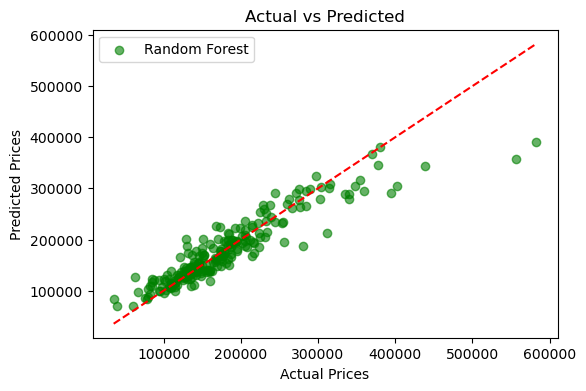

In [20]:
#Step 14:Visualizing the results


# Assuming rf_rmse_mean and lr_rmse_mean are defined
models = ['Random Forest', 'Linear Regression']
rmse_values = [rf_rmse_mean, lr_rmse_mean]



# Actual vs. Predicted Scatter Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_val, y_pred_rf, color='green', alpha=0.6, label='Random Forest')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()


In [21]:
# Display the results
print(f'Median Imputation - Linear Regression RMSE: {lr_rmse_median}, R²: {lr_r2_median}')
print(f'Median Imputation - Random Forest RMSE: {rf_rmse_median}, R²: {rf_r2_median}')
print(f'Mean Imputation - Linear Regression RMSE: {lr_rmse_mean}, R²: {lr_r2_mean}')
print(f'Mean Imputation - Random Forest RMSE: {rf_rmse_mean}, R²: {rf_r2_mean}')

Median Imputation - Linear Regression RMSE: 32926.35511895579, R²: 0.8282700648825003
Median Imputation - Random Forest RMSE: 31610.86982109834, R²: 0.8417179805171866
Mean Imputation - Linear Regression RMSE: 32936.11274167518, R²: 0.8281682665388261
Mean Imputation - Random Forest RMSE: 31556.078019131375, R²: 0.8422662122457301
